In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt
from netCDF4 import date2num,num2date
import cftime
from math import sqrt
import matplotlib.pyplot as plt 
import sys

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score

from MWDC import preprocessing


import dask.dataframe

#### Reading .nc Data

In [2]:
path = ('../../data/ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path, decode_times=False) 
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

## Preprocessing 

#### Transforming data
- This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and, pairs of both dimensions "latitude" and "longitude" will become the columns for each variable

In [3]:
tf_data = preprocessing.datatransformation(data)
tf_data

,"sp(43.0,-33.0)","sp(42.75,-33.0)","sp(42.5,-33.0)","sp(42.25,-33.0)","sp(42.0,-33.0)","sp(41.75,-33.0)","sp(41.5,-33.0)","sp(41.25,-33.0)","sp(41.0,-33.0)","sp(40.75,-33.0)",...,"t2m(35.25,-23.0)","t2m(35.0,-23.0)","t2m(34.75,-23.0)","t2m(34.5,-23.0)","t2m(34.25,-23.0)","t2m(34.0,-23.0)","t2m(33.75,-23.0)","t2m(33.5,-23.0)","t2m(33.25,-23.0)","t2m(33.0,-23.0)"
0.0,102443.676498,102431.303226,102417.453815,102405.135686,102391.629859,102376.995718,102354.929979,102331.617157,102306.463402,102286.930005,...,290.000848,290.122430,290.264916,290.442410,290.577520,290.716088,290.867770,291.004767,291.069088,291.095877
1.0,101345.768122,101317.220943,101287.358812,101259.804210,101229.348230,101197.229473,101161.144651,101128.482946,101095.235875,101068.601739,...,290.632579,290.666912,290.741103,290.869634,290.979348,291.094496,291.188648,291.258157,291.281510,291.312004
2.0,100624.067447,100584.979445,100543.863872,100504.640134,100464.109927,100422.816199,100374.396282,100326.188453,100276.279671,100234.684777,...,290.797767,290.884106,290.933596,290.999557,291.061465,291.153361,291.255193,291.347718,291.426658,291.535552
3.0,100114.540603,100040.682731,99966.880003,99897.586286,99832.547075,99775.380607,99718.328667,99667.461243,99619.999967,99586.044519,...,290.893986,290.875573,290.855689,290.940658,291.090622,291.246660,291.372272,291.492091,291.587344,291.698686
4.0,100697.759889,100618.637969,100538.930682,100461.853300,100384.593521,100308.381461,100226.426032,100147.134440,100068.479115,99995.435665,...,290.343238,290.741350,290.962192,291.019160,291.073186,291.165834,291.315630,291.485410,291.615917,291.696002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,98843.817016,98872.778201,98904.362934,98940.904619,98979.865525,99023.685306,99065.608941,99111.557801,99163.068418,99225.224426,...,292.431912,292.528418,292.677360,292.888889,293.059160,293.161395,293.232289,293.256524,293.238473,293.260666
361.0,98579.721408,98638.305796,98693.424812,98748.838058,98802.518619,98855.263365,98898.519207,98940.773850,98981.140520,99028.262212,...,292.397667,292.426311,292.512561,292.647280,292.745454,292.810912,292.857479,292.888796,292.889274,292.907499
362.0,98894.706481,98944.369990,98993.923163,99046.639304,99101.378273,99158.916511,99210.345398,99260.842557,99311.495004,99370.504390,...,292.438388,292.575405,292.739702,292.944218,293.099881,293.206281,293.277760,293.320371,293.326403,293.347126
363.0,98648.542535,98667.708326,98687.585171,98714.294683,98744.252980,98774.538199,98798.971517,98822.415897,98845.627345,98877.167126,...,292.060683,292.187234,292.369033,292.632800,292.846336,293.011309,293.129716,293.204905,293.263513,293.294713


In [4]:
tf_data = preprocessing.datanormalization(tf_data)


In [5]:
tf_data

,"sp(43.0,-33.0)","sp(42.75,-33.0)","sp(42.5,-33.0)","sp(42.25,-33.0)","sp(42.0,-33.0)","sp(41.75,-33.0)","sp(41.5,-33.0)","sp(41.25,-33.0)","sp(41.0,-33.0)","sp(40.75,-33.0)",...,"t2m(35.25,-23.0)","t2m(35.0,-23.0)","t2m(34.75,-23.0)","t2m(34.5,-23.0)","t2m(34.25,-23.0)","t2m(34.0,-23.0)","t2m(33.75,-23.0)","t2m(33.5,-23.0)","t2m(33.25,-23.0)","t2m(33.0,-23.0)"
0.0,0.769017,0.763551,0.758399,0.754214,0.749653,0.744597,0.739195,0.733298,0.726633,0.719377,...,0.307300,0.312956,0.318721,0.328563,0.334153,0.337154,0.340863,0.343122,0.338263,0.331969
1.0,0.550508,0.539280,0.528615,0.520168,0.510767,0.500749,0.491037,0.481886,0.472325,0.462340,...,0.366677,0.364151,0.363580,0.368759,0.371705,0.372464,0.370914,0.367119,0.358756,0.353140
2.0,0.406872,0.391876,0.377439,0.365852,0.353486,0.340685,0.327491,0.314235,0.300378,0.286403,...,0.382203,0.384572,0.381714,0.380983,0.379379,0.377956,0.377146,0.375601,0.372759,0.375038
3.0,0.305465,0.282306,0.260121,0.241803,0.223679,0.206865,0.191111,0.176584,0.162586,0.149556,...,0.391246,0.383770,0.374375,0.375442,0.382104,0.386662,0.388110,0.389274,0.388262,0.391018
4.0,0.421539,0.398652,0.376436,0.357109,0.337143,0.317032,0.296732,0.276819,0.256749,0.235928,...,0.339481,0.371150,0.384408,0.382828,0.380475,0.379120,0.382806,0.388641,0.391018,0.390756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,0.052561,0.047201,0.044078,0.046307,0.048426,0.051497,0.055427,0.060420,0.066650,0.073432,...,0.535796,0.539179,0.545987,0.558745,0.566072,0.565328,0.562305,0.556372,0.547556,0.544027
361.0,0.000000,0.000000,0.001187,0.007059,0.011975,0.016685,0.020693,0.024733,0.028452,0.031877,...,0.532577,0.529579,0.530462,0.536012,0.536755,0.532624,0.527203,0.521547,0.513866,0.509431
362.0,0.062689,0.061612,0.062288,0.067914,0.073401,0.079448,0.085514,0.091616,0.097813,0.104082,...,0.536404,0.543597,0.551860,0.563950,0.569878,0.569516,0.566563,0.562419,0.556039,0.552496
363.0,0.013697,0.005919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500904,0.507099,0.516941,0.534650,0.546183,0.551323,0.552699,0.551484,0.549971,0.547362


### KernelPCA

- Kernel PCA is a non-linear dimensionality reduction technique that uses kernels. It can also be considered as the non-linear form of normal PCA.

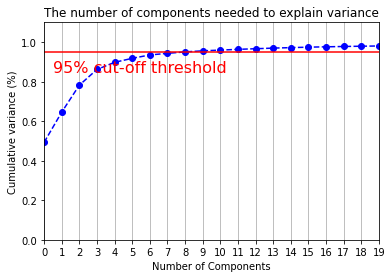

In [6]:
from MWDC import preprocessing
preprocessing.pcacomponents(tf_data)

In [31]:
kpca = KernelPCA(n_components=17, kernel='rbf')
X_kpca = kpca.fit_transform(tf_data)
X_kpca

array([[ 1.80462099e-01, -7.56599956e-02, -5.75912999e-02, ...,
         1.98693316e-02, -2.81406664e-02,  7.42124832e-03],
       [ 1.86028773e-01,  1.75858343e-02, -2.56719931e-02, ...,
         1.79729397e-02, -2.83921681e-02, -8.37374316e-05],
       [ 1.89778076e-01,  1.12495868e-01,  1.84553671e-02, ...,
         2.02571698e-02, -4.82167996e-03, -3.82794243e-03],
       ...,
       [ 1.78166565e-01,  2.43505303e-01,  9.40924637e-02, ...,
        -2.37209967e-03,  7.21076001e-03, -1.62308640e-02],
       [ 1.96398575e-01,  2.63347194e-01,  1.72911266e-01, ...,
         4.41335896e-03, -4.13612701e-02, -1.51954963e-02],
       [ 1.99584289e-01,  2.00915992e-01,  2.68376678e-01, ...,
         2.01009479e-02, -3.71403956e-02, -2.73063214e-02]])

In [32]:
X_kpca.shape

(365, 17)

In [33]:
distortions = []
inertias = []
K = range(1,70, 3)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_kpca)
    distortions.append(sum(np.min(cdist(X_kpca, km.cluster_centers_,'euclidean'), axis=1)) / X_kpca.shape[0])
    inertias.append(km.inertia_)


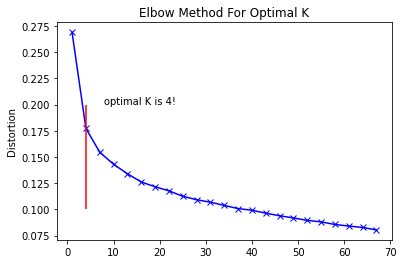

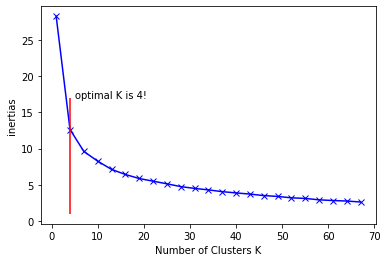

In [71]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=0.1, ymax=0.2, x=4, colors='red')
plt.text(x=8, y=0.2, s="optimal K is 4!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=1, ymax=17, x=4, colors='red')
plt.text(x=5, y=17, s="optimal K is 4!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [72]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_kpca)
P = kmeans.predict(X_kpca)
labels =  kmeans.labels_
frame = pd.DataFrame(X_kpca)
frame['Cluster'] = labels
labels

array([0, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Evaluation

### RMSE

In [19]:
# Non-normalized
# Function that creates a dictionary that holds the values of dates in each cluster
def get_datewise_clusters(formed_clusters): # classification
  Dates_Cluster = {}
  for i in set(formed_clusters): # classification
    Dates_Cluster['Dates_Cluster'+str(i)] = trans_data.index[trans_data.Cluster == i].to_list()
  return Dates_Cluster

# Non-normalized
# Function that creats a dictionary that holds all the clusters
def n_nor_get_clusters(input,formed_clusters): # classification
  com_arr = []
  Clusters = {}
  Dates_Cluster = get_datewise_clusters(formed_clusters)
  for i in set(formed_clusters):
    for j in Dates_Cluster['Dates_Cluster'+str(i)]:
      arr = np.array(input.isel(time=j).to_array()) # input is data
      com_arr.append(arr)
    Clusters['Cluster' + str(i)] = np.array(com_arr)
    com_arr = []
  return Clusters

# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

# Non-normalized
def handle_missing_values(input):
  var_mean = {}
  for i in input.data_vars:
    if input[i].isnull().sum().item() > 0:
      print(i,'has null values')
      var_mean[str(i) + '_mean'] = input[i].mean().item()
      input[i] = input[i].fillna(var_mean[str(i) + '_mean'])
  return input


# Non-normalized 
#Intra RMSE Calculation Function
def n_nor_intra_rmse(input,formed_clusters):
  sq_diff = []
  intra_rmse = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sq_diff)
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n))))
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse


###########################  RMSE Computation  #######################################


# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers
def nor_get_clusters_and_centers(input,formed_clusters):
  Clusters = {}
  Cluster_Centers = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Clusters,Cluster_Centers

# Normalized
# Intra RMSE Calculation Function
def nor_intra_rmse(input,formed_clusters):
  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sum(sq_diff))
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

# RMSE Calculation
def RMSE(input,formed_clusters,frame,normalize=False):
  inter_rmse = []
  avg_cluster = {}

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_rmse(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(sum(sum(Sq_diff)))
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          n = len(avg_cluster['avg_cluster'+str(i)][0])
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  else:

  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(frame,formed_clusters)

    # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = nor_intra_rmse(frame,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(Sq_diff)
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())

  return mat


In [70]:

RMSE(tf_data,labels,frame,True)

,0,1,2,3
0,0.18,0.34,0.22,0.34
1,0.34,0.18,0.41,0.48
2,0.22,0.41,0.18,0.32
3,0.34,0.48,0.32,0.25


### Silhouette Coefficient score

- The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [68]:
print("Silhouette Coefficient score for K=5 is ", silhouette_score(tf_data, labels))

Silhouette Coefficient score for K=5 is  0.28525614609003164


### Davies-Bouldin score

- The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.

- The minimum score is zero, with lower values indicating better clustering.

In [69]:
print("Davies-Bouldin score for K=7 is ", davies_bouldin_score(tf_data, labels))

Davies-Bouldin score for K=7 is  1.4109212385645842


### Spatial Correlation

In [ ]:
evaluation.Spat_Corr(data,labels,tf_data,True)

Long Run-time!

## Visualization

In [2]:
from MWDC.Visualization.make_Csv_cluster import make_Csv_cluster

In [3]:
make_Csv_cluster(labels,'daily.csv')

NameError: name 'labels' is not defined

In [1]:
from MWDC.Visualization.Visualization import visualization

NameError: name 'path_to_module' is not defined

total clusters:  7
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


../../MWDC/Visualization/Visualization.py:129: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


AttributeError: 'QuadContourSet' object has no attribute 'ax'

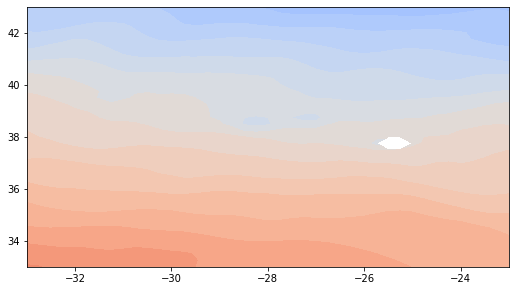

In [140]:
visualization('./ERA5_meteo_sfc_2021_daily.nc','./daily.csv','./coast.txt')
